In [1]:
import torch
import pandas as pd
from pandas import DataFrame
import os
import numpy as np
import albumentations as A
import cv2
import math
import matplotlib.pyplot as plt
import random
from collections import OrderedDict
import json
import multiprocessing
from tqdm import tqdm
import _thread
import time
import threading


In [2]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

setup_seed(2022)

In [3]:
with open("data/train.json") as f:
    dir_train = json.load(f)
with open("data/valid.json") as f:
    dir_valid = json.load(f)

In [4]:
dir_train_nobox = OrderedDict()
for path, boxes in dir_train.items():
    if len(boxes) == 0:
        dir_train_nobox[path] = boxes
len(dir_train_nobox)

1470

In [5]:
label = []
with open("data/label.json") as f:
    dir_label = json.load(f)
for key in dir_label.keys():
    label.append(key)
print(dir_label)
print(label)

{'大螟': 0, '二化螟': 1, '稻纵卷叶螟': 2, '白背飞虱': 3, '褐飞虱属': 4, '地老虎': 5, '蝼蛄': 6, '粘虫': 7, '草地螟': 8, '甜菜夜蛾': 9, '黄足猎蝽': 10, '八点灰灯蛾': 11, '棉铃虫': 12, '二点委夜蛾': 13, '甘蓝夜蛾': 14, '蟋蟀': 15, '黄毒蛾': 16, '稻螟蛉': 17, '紫条尺蛾': 18, '水螟蛾': 19, '线委夜蛾': 20, '甜菜白带野螟': 21, '歧角螟': 22, '瓜绢野螟': 23, '豆野螟': 24, '石蛾': 25, '大黑鳃金龟': 26, '干纹冬夜蛾': 27}
['大螟', '二化螟', '稻纵卷叶螟', '白背飞虱', '褐飞虱属', '地老虎', '蝼蛄', '粘虫', '草地螟', '甜菜夜蛾', '黄足猎蝽', '八点灰灯蛾', '棉铃虫', '二点委夜蛾', '甘蓝夜蛾', '蟋蟀', '黄毒蛾', '稻螟蛉', '紫条尺蛾', '水螟蛾', '线委夜蛾', '甜菜白带野螟', '歧角螟', '瓜绢野螟', '豆野螟', '石蛾', '大黑鳃金龟', '干纹冬夜蛾']


In [6]:
dir_label_num = OrderedDict()
dir_train_label_num = OrderedDict()
dir_valid_label_num = OrderedDict()
for path, boxes in dir_train.items():
    for box in boxes:
        try:
            dir_train_label_num[label[box[0]]] += 1
        except:
            dir_train_label_num[label[box[0]]] = 1
        try:
            dir_label_num[label[box[0]]] += 1
        except:
            dir_label_num[label[box[0]]] = 1
for path, boxes in dir_valid.items():
    for box in boxes:
        try:
            dir_valid_label_num[label[box[0]]] += 1
        except:
            dir_valid_label_num[label[box[0]]] = 1
        try:
            dir_label_num[label[box[0]]] += 1
        except:
            dir_label_num[label[box[0]]] = 1
print(dir_label_num)
print(dir_train_label_num)
print(dir_valid_label_num)


OrderedDict([('褐飞虱属', 150), ('歧角螟', 7), ('八点灰灯蛾', 247), ('蟋蟀', 87), ('甜菜夜蛾', 17), ('棉铃虫', 20), ('水螟蛾', 3), ('稻纵卷叶螟', 18), ('白背飞虱', 120), ('黄毒蛾', 40), ('甜菜白带野螟', 15), ('二化螟', 90), ('二点委夜蛾', 21), ('粘虫', 27), ('黄足猎蝽', 59), ('蝼蛄', 14), ('石蛾', 18), ('大螟', 20), ('紫条尺蛾', 4), ('甘蓝夜蛾', 5), ('大黑鳃金龟', 12), ('地老虎', 4), ('线委夜蛾', 5), ('草地螟', 6), ('稻螟蛉', 4), ('瓜绢野螟', 4), ('干纹冬夜蛾', 1), ('豆野螟', 1)])
OrderedDict([('褐飞虱属', 129), ('歧角螟', 6), ('八点灰灯蛾', 237), ('蟋蟀', 81), ('甜菜夜蛾', 12), ('棉铃虫', 18), ('水螟蛾', 3), ('稻纵卷叶螟', 14), ('白背飞虱', 110), ('黄毒蛾', 38), ('甜菜白带野螟', 13), ('二化螟', 86), ('二点委夜蛾', 21), ('粘虫', 23), ('黄足猎蝽', 54), ('蝼蛄', 13), ('石蛾', 16), ('大螟', 19), ('紫条尺蛾', 4), ('甘蓝夜蛾', 5), ('大黑鳃金龟', 11), ('地老虎', 3), ('线委夜蛾', 4), ('草地螟', 6), ('稻螟蛉', 2), ('瓜绢野螟', 3), ('干纹冬夜蛾', 1)])
OrderedDict([('八点灰灯蛾', 10), ('褐飞虱属', 21), ('蟋蟀', 6), ('黄毒蛾', 2), ('甜菜夜蛾', 5), ('白背飞虱', 10), ('黄足猎蝽', 5), ('甜菜白带野螟', 2), ('棉铃虫', 2), ('稻纵卷叶螟', 4), ('大螟', 1), ('地老虎', 1), ('歧角螟', 1), ('二化螟', 4), ('粘虫', 4), ('豆野螟', 1), ('石蛾', 2), ('线委夜蛾', 1), 

In [7]:
def IoU(box1, box2):
    # 计算中间矩形的宽高
    in_h = min(box1[2], box2[2]) - max(box1[0], box2[0])
    in_w = min(box1[3], box2[3]) - max(box1[1], box2[1])

    # 计算交集、并集面积
    inter = 0 if in_h < 0 or in_w < 0 else in_h * in_w
    union = (
        (box1[2] - box1[0]) * (box1[3] - box1[1])
        + (box2[2] - box2[0]) * (box2[3] - box2[1])
        - inter
    )
    # 计算IoU
    iou = inter / union
    return iou


In [8]:
num = 0
dir_expand_train = OrderedDict()


def cut_train(image_path, save_dir, boxes, shape):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    global num
    img = cv2.imread(image_path)
    h, w = img.shape[:2]
    for box in boxes:
        center_x, center_y = int(box[1] + (box[3] - box[1]) / 2), int(
            (box[4] - box[2]) / 2 + box[2]
        )
        x, y, r, b = (
            center_x - shape // 2,
            center_y - shape // 2,
            center_x + shape // 2,
            center_y + shape // 2,
        )
        x = max(0, x)
        y = max(0, y)
        r = min(r, w)
        b = min(b, h)
        num += 1
        path = os.path.join(save_dir, str(num) + ".png").replace("\\", "/")
        annotations = []
        cv2.imwrite(path, img[y:b, x:r], [int(cv2.IMWRITE_JPEG_QUALITY), 100])
        for e_box in boxes:
            if (
                not (e_box[1] >= r or e_box[3] <= x or e_box[2] >= b or e_box[4] <= y)
            ) and IoU(
                [
                    max(x, e_box[1]),
                    max(y, e_box[2]),
                    min(r, e_box[3]),
                    min(b, e_box[4]),
                ],
                e_box[1:5],
            ) >= 0.3:
                e_box = [int(x) for x in e_box]
                # print(e_box[1:5])
                e_box[1] = max(0, e_box[1] - x)
                e_box[2] = max(0, e_box[2] - y)
                e_box[3] = min(r, e_box[3] - x)
                e_box[4] = min(b, e_box[4] - y)
                annotations.append(e_box)
        dir_expand_train[path] = annotations


for path, boxes in tqdm(dir_train.items(), total=len(dir_train)):
    t_thread = threading.Thread(target=cut_train ,args=(path, "mydataset1/images/expand_train", boxes, 1280))
    t_thread.start() 
    # cut_train(path, "mydataset1/images/expand_train", dir_train[path], 1280) 


100%|██████████| 1991/1991 [02:10<00:00, 15.30it/s]


In [9]:
def cutmix_train(image_path, save_dir, boxes, shape):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    global num
    for box in boxes:
        if dir_train_label_num[label[box[0]]] > 80:
            continue
        box = [int(x) for x in box]
        box_img = cv2.imread(image_path)[box[2] : box[4], box[1] : box[3]]
        box_w = box[3] - box[1]
        box_h = box[4] - box[2]
        cutmix_num = (80 - dir_train_label_num[label[box[0]]]) // dir_train_label_num[
            label[box[0]]
        ]
        back_img_paths = random.sample(dir_train_nobox.keys(), cutmix_num)
        for back_img_path in back_img_paths:
            back_img = cv2.imread(back_img_path)
            h, w = back_img.shape[:2]
            x = random.randint(0, w - shape)
            y = random.randint(0, h - shape)
            r = x + shape
            b = y + shape
            cutmix_img = back_img[y:b, x:r]
            cutmix_x = max(0, shape // 2 - box_w // 2)
            cutmix_y = max(0, shape // 2 - box_h // 2)
            cutmix_r = min(shape, shape // 2 + box_w // 2)
            cutmix_b = min(shape, shape // 2 + box_h // 2)
            # print(cutmix_img.shape)
            # print([cutmix_y, cutmix_b, cutmix_x, cutmix_r])
            cutmix_img[cutmix_y:cutmix_b, cutmix_x:cutmix_r] = box_img[
                0 : (cutmix_b - cutmix_y),
                0 : (cutmix_r - cutmix_x),
            ]
            num += 1
            cutmix_path = os.path.join(save_dir, str(num) + ".png").replace("\\", "/")
            annotations = [[box[0], cutmix_x, cutmix_y, cutmix_r, cutmix_b]]
            dir_expand_train[cutmix_path] = annotations
            cv2.imwrite(cutmix_path, cutmix_img, [int(cv2.IMWRITE_JPEG_QUALITY), 100])


# cutmix_train("mydataset1/images/expand_train", 1280)

for path, boxes in tqdm(dir_train.items(), total=len(dir_train)):
    t_thread = threading.Thread(target=cutmix_train ,args=(path, "mydataset1/images/expand_train", boxes, 1280))
    t_thread.start()
    # cutmix_train(path, "mydataset1/images/expand_train", boxes, 1280)


 34%|███▍      | 679/1991 [00:36<02:35,  8.45it/s]Exception in thread Thread-2657:
Traceback (most recent call last):
  File "D:\Anaconda\envs\pytorch\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "D:\Anaconda\envs\pytorch\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Osilly\AppData\Local\Temp/ipykernel_20088/302274043.py", line 36, in cutmix_train
    - (cutmix_r - cutmix_x) // 2 + (cutmix_r - cutmix_x),
ValueError: could not broadcast input array from shape (624,562,3) into shape (636,562,3)

 34%|███▍      | 681/1991 [00:36<02:37,  8.30it/s]Exception in thread Thread-2661:
Traceback (most recent call last):
  File "D:\Anaconda\envs\pytorch\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "D:\Anaconda\envs\pytorch\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Osilly\AppData\Local\Temp/ipykernel_20088/302274043.py", line 36, in cutmix

In [20]:
# 将没有分到训练集的类加入
for path, boxes in dir_valid.items():
    for box in boxes:
        if label[box[0]] in dir_train_label_num.keys():
            continue
        shape = 1280
        box = [int(x) for x in box]
        box_img = cv2.imread(path)[box[2] : box[4], box[1] : box[3]]
        box_w = box[3] - box[1]
        box_h = box[4] - box[2]
        cutmix_num = 80
        back_img_paths = random.sample(dir_train_nobox.keys(), cutmix_num)
        for back_img_path in back_img_paths:
            back_img = cv2.imread(back_img_path)
            h, w = back_img.shape[:2]
            x = random.randint(0, w - shape)
            y = random.randint(0, h - shape)
            r = x + shape
            b = y + shape
            cutmix_img = back_img[y:b, x:r]
            cutmix_x = max(0, shape // 2 - box_w // 2)
            cutmix_y = max(0, shape // 2 - box_h // 2)
            cutmix_r = min(shape, shape // 2 + box_w // 2)
            cutmix_b = min(shape, shape // 2 + box_h // 2)
            cutmix_img[cutmix_y:cutmix_b, cutmix_x:cutmix_r] = box_img[
                0 : (cutmix_b - cutmix_y),
                0 : (cutmix_r - cutmix_x),
            ]
            num += 1
            cutmix_path = os.path.join("mydataset1/images/expand_train", str(num) + ".png").replace("\\", "/")
            annotations = [[box[0], cutmix_x, cutmix_y, cutmix_r, cutmix_b]]
            dir_expand_train[cutmix_path] = annotations
            cv2.imwrite(cutmix_path, cutmix_img, [int(cv2.IMWRITE_JPEG_QUALITY), 100])

In [21]:
json_expend_train = json.dumps(dir_expand_train.copy(), indent=4)
with open("mydataset1/expand_train.json", "w+") as f:
    f.write(json_expend_train)

In [32]:
for i, (path, boxes) in enumerate(dir_expand_train.copy().items()):
    if i != 127:
        continue
    img = cv2.imread(path)
    for box in boxes:
        a = cv2.rectangle(
            img, (box[1], box[2]), (box[3], box[4]), color=(255, 0, 0), thickness=2
        )
    plt.imshow(a)
    plt.show()


In [24]:
dir_enhanced_train_label_num = OrderedDict()
for path, boxes in dir_expand_train.items():
    for box in boxes:
        try:
            dir_enhanced_train_label_num[label[box[0]]] += 1
        except:
            dir_enhanced_train_label_num[label[box[0]]] = 1
dir_enhanced_train_label_num

OrderedDict([('八点灰灯蛾', 305),
             ('甜菜夜蛾', 72),
             ('褐飞虱属', 150),
             ('水螟蛾', 78),
             ('稻纵卷叶螟', 71),
             ('蟋蟀', 113),
             ('白背飞虱', 130),
             ('棉铃虫', 72),
             ('二化螟', 99),
             ('黄毒蛾', 81),
             ('歧角螟', 78),
             ('甜菜白带野螟', 83),
             ('粘虫', 71),
             ('黄足猎蝽', 77),
             ('二点委夜蛾', 63),
             ('蝼蛄', 80),
             ('石蛾', 81),
             ('大螟', 83),
             ('紫条尺蛾', 83),
             ('甘蓝夜蛾', 82),
             ('大黑鳃金龟', 67),
             ('地老虎', 78),
             ('线委夜蛾', 81),
             ('草地螟', 45),
             ('稻螟蛉', 80),
             ('瓜绢野螟', 81),
             ('干纹冬夜蛾', 80),
             ('豆野螟', 85)])

In [25]:
num = 0
dir_expand_valid = OrderedDict()


def cut_valid(image_path, save_dir, boxes, window_shape, step):
    global num
    img = cv2.imread(image_path)
    h, w = img.shape[:2]
    window_left, window_right = (0, 0), (window_shape, window_shape)
    if not os.path.exists(save_dir):
            os.makedirs(save_dir)
    for i in range(0, w, step):
        for j in range(0, h, step):
            window_left = (i, j)     
            window_right = (min(i + window_shape, w), min(j + window_shape, h))
            x, y = window_left
            r, b = window_right
            annotations = []
            for e_box in boxes:
                if (
                    not (e_box[1] >= r or e_box[3] <= x or e_box[2] >= b or e_box[4] <= y)
                ) and IoU(
                    [
                        max(x, e_box[1]),
                        max(y, e_box[2]),
                        min(r, e_box[3]),
                        min(b, e_box[4]),
                    ],
                    e_box[1:5],
                ) >= 0.3:
                    e_box = [int(x) for x in e_box]
                    # print(e_box[1:5])
                    e_box[1] = max(0, e_box[1] - x)
                    e_box[2] = max(0, e_box[2] - y)
                    e_box[3] = min(r, e_box[3] - x)
                    e_box[4] = min(b, e_box[4] - y)
                    annotations.append(e_box)
            if len(annotations) == 0:
                continue
            num += 1
            path = os.path.join(save_dir, str(num) + ".png").replace("\\", "/")
            cv2.imwrite(
                path,
                img[y:b, x:r],
                [int(cv2.IMWRITE_JPEG_QUALITY), 100],
            )
            dir_expand_valid[path] = annotations     


for path in tqdm(dir_valid.keys(), total=len(dir_valid)):
    t_thread = threading.Thread(target=cut_valid ,args=(path, "mydataset1/images/expand_valid", dir_valid[path], 1280, 640))
    t_thread.start()  
    # cut_valid(path, "mydataset1/images/expand_valid", dir_valid[path], 1280, 640)

100%|██████████| 222/222 [00:18<00:00, 12.24it/s]


In [27]:
json_expend_valid = json.dumps(dir_expand_valid.copy(), indent=4)
with open("mydataset1/expand_valid.json", "w+") as f:
    f.write(json_expend_valid)                      
# cut_valid("data/image/01992.jpg", "data/expand_valid_image", dir_valid["data/image/01992.jpg"], 1024, 512)

mydataset1/images/expand_valid/1.png


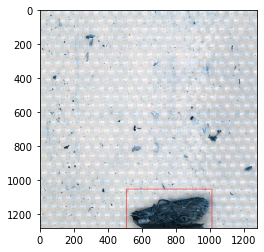

mydataset1/images/expand_valid/2.png


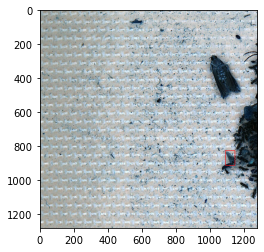

mydataset1/images/expand_valid/3.png


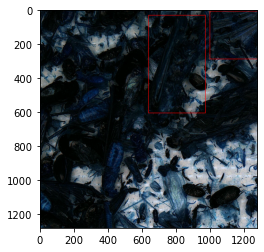

mydataset1/images/expand_valid/4.png


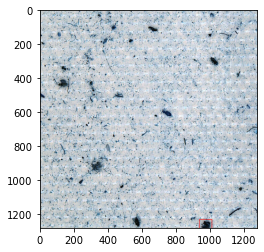

mydataset1/images/expand_valid/5.png


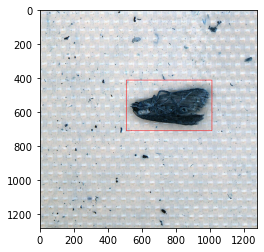

In [28]:
for i, (path, boxes) in enumerate(dir_expand_valid.copy().items()):
    if i>= 5:
        continue
    img = cv2.imread(path)
    for box in boxes:
        a = cv2.rectangle(
            img, (box[1], box[2]), (box[3], box[4]), color=(255, 0, 0), thickness=2
        )
    print(path)
    plt.imshow(a)
    plt.show()
